In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'E:/Documents/4th year Project/Training_Data'
TEST_DIR = 'E:/Documents/4th year Project/Testing_Data'

IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'COAST SHIP CLASSIFIER'

In [2]:
def label_img(wordlabel):
    if wordlabel == 'Ship':
        return [1,0]
    elif wordlabel == 'Coast':
        return [0,1]
    

In [3]:
def create_train_data():
    training_data = []
    for train_file in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(train_file)
        temp_path = str(os.path.join(TRAIN_DIR, train_file))
        for img in tqdm (os.listdir(temp_path)):
            path=os.path.join(TRAIN_DIR, train_file,img)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE, IMG_SIZE))
            training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        print (img_num)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), np.array(img_num)])
    np.save('test_data.npy', testing_data)
    return testing_data


In [5]:
train_data = create_train_data()

 46%|████████████████████████████████████▋                                          | 470/1012 [00:07<00:12, 42.85it/s]


 92%|████████████████████████████████████████████████████████████████████████▋      | 931/1012 [00:16<00:01, 56.49it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00, 13.03s/it]


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

for i in range(5):
    convnet = conv_2d(convnet, 32, 2, activation='relu')
    convnet = max_pool_2d(convnet, 2)

    convnet = conv_2d(convnet, 64, 2, activation='relu')
    convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
# if os.path.exists('{}.meta'.format(MODEL_NAME)):
    # model.load(MODEL_NAME)
    # print ('Model Loaded!')

In [8]:
train = train_data[:500]
test = train_data[-500:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}),snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 79  | total loss: 0.24110 | time: 2.634s
| Adam | epoch: 010 | loss: 0.24110 - acc: 0.9086 -- iter: 448/500
Training Step: 80  | total loss: 0.23379 | time: 4.008s
| Adam | epoch: 010 | loss: 0.23379 - acc: 0.9100 | val_loss: 0.16672 - val_acc: 0.9500 -- iter: 500/500
--


In [11]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\HP\COAST SHIP CLASSIFIER is not in all_model_checkpoint_paths. Manually adding it.


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

c1013
c1015
c1052
d1781
d1782
d1783


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 66.65it/s]


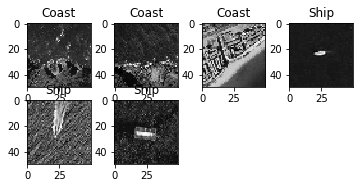

In [13]:
import matplotlib.pyplot as plt

test_data = process_test_data()
fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1:
        str_label = 'Coast'
    else:
        str_label = 'Ship'
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_xaxis().set_visible(True)
plt.show()